In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

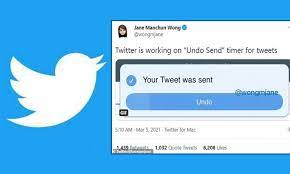
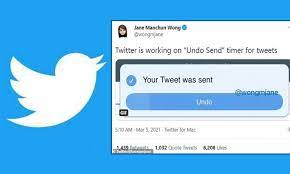

# Import Dataset

In [ ]:
df=pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='latin1')
df.head()

In [ ]:
df.shape

# Unique Values and Counts of Sentiments

In [ ]:
df["Sentiment"].unique()

In [ ]:
sns.countplot(df["Sentiment"])

In [ ]:
# Keeping the important columns only and removing the rest 
df=df[["OriginalTweet","Sentiment"]]

In [ ]:
df.head()

# Visualizing unique Sentiments

In [ ]:
labels=['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']
sizes = [
         df[df['Sentiment'] == 'Extremely Negative'].shape[0], 
         df[df['Sentiment'] == 'Extremely Positive'].shape[0],
         df[df['Sentiment'] == 'Negative'].shape[0], 
         df[df['Sentiment'] == 'Neutral'].shape[0],
         df[df['Sentiment'] == 'Positive'].shape[0]
        ]
plt.pie(sizes,labels=labels, data=df, autopct='%1.2f%%', shadow=True, startangle=90)
plt.title("Sentiments percentages in train data")
plt.axis("equal")

# Combining similar Sentiments

In [ ]:
#Combining the two sentiments as a single sentiment.
for i in ["Extremely Negative","Negative"]:
    df.loc[df["Sentiment"]==i,"Sentiment"]="Negative"

In [ ]:
#Combining the two sentiments as a single sentiment.
for j in ["Extremely Positive","Positive"]:
    df.loc[df["Sentiment"]==j,"Sentiment"]="Positive"

In [ ]:
#Now you can see that there are only three sentiments.
df["Sentiment"].unique()

In [ ]:
sns.countplot(df["Sentiment"])

In [ ]:
labels=['Negative', 'Neutral', 'Positive']
sizes = [
         
         df[df['Sentiment'] == 'Negative'].shape[0], 
         df[df['Sentiment'] == 'Neutral'].shape[0],
         df[df['Sentiment'] == 'Positive'].shape[0]
        ]
plt.pie(sizes,labels=labels, data=df, autopct='%1.2f%%', shadow=True, startangle=90)
plt.title("Sentiments percentages in train data")
plt.axis("equal")

In [ ]:
X=df["OriginalTweet"]
y=df["Sentiment"]

# Data Preprocessing

# Importing NLP libraries

In [ ]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot

In [ ]:
messages=X.copy()

In [ ]:
messages.shape

In [ ]:
messages.head()

In [ ]:
ps=PorterStemmer()

In [ ]:
corpus=[]
for i in range(len(messages)):
    #removing everything other than alphabets
    review=re.sub("[^a-zA-Z]"," ", str(messages[i]))
    #remove urls
    text = re.sub(r'http\S+', " ", str(messages[i]))
    #remove mentions
    text = re.sub(r'@\w+',' ', str(messages[i]))
    #remove hastags
    text = re.sub(r'#\w+', ' ', str(messages[i]))
    #remove html tags
    text = re.sub('r<.*?>',' ', str(messages[i]))
    #Lowering the tweets
    review=review.lower()
    #Converting into a list
    review=review.split()
    #Removing the Stopwords
    review=[ps.stem(word) for word in review if not word in stopwords.words("english")]
    #Joining the list 
    review=" ".join(review)
    corpus.append(review)

# Encoding the dependant variable 

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(y)

**Different Sentiments with values**

Extremely Negative --> 0

Extremely Postive --> 1

Negative --> 2

Neutral --> 3

Positive --> 4

In [ ]:
#Setting the vocabulary size
voc_size=5000

In [ ]:
#we will do one hot encoding for the corpus. It is alloting every word an index according to the vocabulary size
onehot=[one_hot(words,voc_size) for words in corpus]

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#if length of sentence is not 20 than it will ad 0 in front of sentence such that length becomes 20
embedded_docs=pad_sequences(onehot,padding="pre",maxlen=305)

# Model Creation

In [ ]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D, Input, GlobalMaxPool1D
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical

In [ ]:
model = Sequential([
    Embedding(voc_size+1,305, input_length=len(embedded_docs[0])),
    Dropout(0.5),
    Bidirectional(LSTM(200, return_sequences=True)),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
len(embedded_docs),y.shape

In [ ]:
#Converting y to categorical with 3 features
y = to_categorical(y,3)

In [ ]:
#Creating new independent and dependent variables
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_final,y_final,test_size=0.3,random_state=0)

# Training the Model

In [ ]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64)

# Visualising the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()